<a href="https://colab.research.google.com/github/LOG1C32/Laser-turret/blob/master/CNN/Krishicare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!unzip drive/MyDrive/Krishicare/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2938.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2939.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy294.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2940.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2941.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2942.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2943.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2944.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2945.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2946.jpg  
  inflating: Image Data base/Image Data base/Tomato healthy/Tomato_healthy2947.jpg  
  inflating: Im

In [4]:
import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
sns.set_style('darkgrid')
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
import time

In [5]:
dir=r'/content/Image Data base/Image Data base'
min_samples=40 # set limit for minimum images a class must have to be included in the dataframe
filepaths = []
labels=[] 
classlist=os.listdir(dir)   
for klass in classlist:
    classpath=os.path.join(dir, klass)
    flist=os.listdir(classpath)
    if len(flist) >= min_samples:
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    else:
        print('class ', klass, ' has only', len(flist), ' samples and will not be included in dataframe')

class  Nitrogen deficiency in plant  has only 33  samples and will not be included in dataframe
class  Waterlogging in plant  has only 21  samples and will not be included in dataframe


In [6]:
Fseries=pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')        
df=pd.concat([Fseries, Lseries], axis=1)
train_df, dummy_df=train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=df['labels'])
valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df lenght:  179649   test_df length:  9981   valid_df length:  9981


In [7]:
classes=sorted(list(train_df['labels'].unique()))
class_count = len(classes)
print('The number of classes in the dataset is: ', class_count)
groups=train_df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))

The number of classes in the dataset is:  56
            CLASS               IMAGE COUNT 


In [8]:
countlist=[]
classlist=[]
for label in sorted(list(train_df['labels'].unique())):
    group=groups.get_group(label)
    countlist.append(len(group))
    classlist.append(label)
    print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
    

       Apple Apple scab            5443     
       Apple Black rot             5368     
    Apple Cedar apple rust         2376     
        Apple healthy              3553     
Bacterial leaf blight in rice leaf      108     
     Blight in corn Leaf           3094     
      Blueberry healthy            3245     
   Brown spot in rice leaf          108     
     Cercospora leaf spot           170     
Cherry (including sour) Powdery mildew     2273     
Cherry (including_sour) healthy     1847     
   Common Rust in corn Leaf        3526     
     Corn (maize) healthy          2511     
            Garlic                  132     
       Grape Black rot             10195    
   Grape Esca Black Measles        11956    
Grape Leaf blight Isariopsis Leaf Spot     9299     
        Grape healthy               915     
 Gray Leaf Spot in corn Leaf       1550     
    Leaf smut in rice leaf          108     
Orange Haunglongbing Citrus greening     47585    
        Peach healthy       

In [9]:
max_value=np.max(countlist)
max_index=countlist.index(max_value)
max_class=classlist[max_index]
min_value=np.min(countlist)
min_index=countlist.index(min_value)
min_class=classlist[min_index]
print(max_class, ' has the most images= ',max_value, ' ', min_class, ' has the least images= ', min_value)

ht=0
wt=0

train_df_sample=train_df.sample(n=100, random_state=123,axis=0)
for i in range (len(train_df_sample)):
    fpath=train_df_sample['filepaths'].iloc[i]
    img=plt.imread(fpath)
    shape=img.shape
    ht += shape[0]
    wt += shape[1]
print('average height= ', ht//100, ' average width= ', wt//100, 'aspect ratio= ', ht/wt)

Orange Haunglongbing Citrus greening  has the most images=  47585   potassium deficiency in plant  has the least images=  49
average height=  263  average width=  261 aspect ratio=  1.0098039215686274


In [10]:
diseases = os.listdir(dir)
print(diseases)

['Tomato healthy', 'potato crop', 'Raspberry healthy', 'Cercospora leaf spot', 'Tomato Spider mites Two spotted spider mite', 'algal leaf in tea', 'onion', 'potassium deficiency in plant', 'bird eye spot in tea', 'ginger', 'Pepper bell Bacterial spot', 'red leaf spot in tea', 'anthracnose in tea', 'Apple healthy', 'Leaf smut in rice leaf', 'Nitrogen deficiency in plant', 'Strawberry Leaf scorch', 'Tomato Septoria leaf spot', 'Common Rust in corn Leaf', 'potato hollow heart', 'Brown spot in rice leaf', 'Tomato Early blight', 'Grape Black rot', 'Bacterial leaf blight in rice leaf', 'cabbage looper', 'Grape Esca Black Measles', 'Waterlogging in plant', 'healthy tea leaf', 'Potato Late blight', 'Apple Black rot', 'Tomato Target Spot', 'Soybean healthy', 'Tomato Bacterial spot', 'Peach healthy', 'Corn (maize) healthy', 'Potato Early blight', 'Apple Cedar apple rust', 'Grape healthy', 'Gray Leaf Spot in corn Leaf', 'Tomato Leaf Mold', 'corn crop', 'Grape Leaf blight Isariopsis Leaf Spot', 'T

In [11]:
print("Total disease classes are: {}".format(len(diseases)))

Total disease classes are: 58


In [12]:
def trim(df, max_samples, min_samples, column):
    df=df.copy()
    groups=df.groupby(column)    
    trimmed_df = pd.DataFrame(columns = df.columns)
    groups=df.groupby(column)
    for label in df[column].unique(): 
        group=groups.get_group(label)
        count=len(group)    
        if count > max_samples:
            sampled_group=group.sample(n=max_samples, random_state=123,axis=0)
            trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
        else:
            if count>=min_samples:
                sampled_group=group        
                trimmed_df=pd.concat([trimmed_df, sampled_group], axis=0)
    print('after trimming, the maximum samples in any class is now ',max_samples, ' and the minimum samples in any class is ', min_samples)
    return trimmed_df



In [13]:
max_samples=200 # since each class has more than 200 images all classes will be trimmed to have 200 images per class
min_samples=36
column='labels'
train_df= trim(train_df, max_samples, min_samples, column)

after trimming, the maximum samples in any class is now  200  and the minimum samples in any class is  36


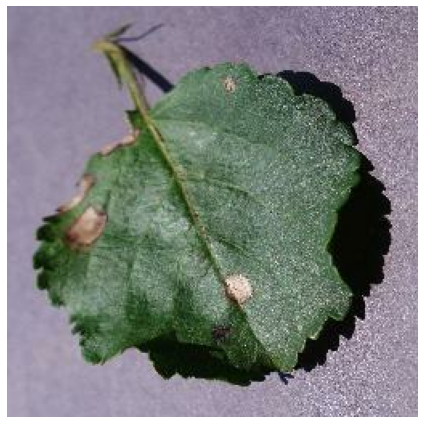

In [14]:
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')

image_path = '/content/Image Data base/Image Data base/Apple Black rot/Apple_Black_rot1002.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

In [15]:
def balance(df, n, working_dir, img_size):
    df=df.copy()
    print('Initial length of dataframe is ', len(df))
    aug_dir=os.path.join(working_dir, 'aug')# directory to store augmented images
    if os.path.isdir(aug_dir):# start with an empty directory
        shutil.rmtree(aug_dir)
    os.mkdir(aug_dir)        
    for label in df['labels'].unique():    
        dir_path=os.path.join(aug_dir,label)    
        os.mkdir(dir_path) # make class directories within aug directory
    # create and store the augmented images  
    total=0
    gen=ImageDataGenerator(horizontal_flip=True,  rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2)
    groups=df.groupby('labels') # group by class
    for label in df['labels'].unique():  # for every class               
        group=groups.get_group(label)  # a dataframe holding only rows with the specified label 
        sample_count=len(group)   # determine how many samples there are in this class        
        if sample_count< n: # if the class has less than target number of images
            aug_img_count=0
            delta=n - sample_count  # number of augmented images to create
            target_dir=os.path.join(aug_dir, label)  # define where to write the images
            msg='{0:40s} for class {1:^30s} creating {2:^5s} augmented images'.format(' ', label, str(delta))
            print(msg, '\r', end='') # prints over on the same line
            aug_gen=gen.flow_from_dataframe( group,  x_col='filepaths', y_col=None, target_size=img_size,
                                            class_mode=None, batch_size=1, shuffle=False, 
                                            save_to_dir=target_dir, save_prefix='aug-', color_mode='rgb',
                                            save_format='jpg')
            while aug_img_count<delta:
                images=next(aug_gen)            
                aug_img_count += len(images)
            total +=aug_img_count
    print('Total Augmented images created= ', total)
    # create aug_df and merge with train_df to create composite training set ndf
    aug_fpaths=[]
    aug_labels=[]
    classlist=os.listdir(aug_dir)
    for klass in classlist:
        classpath=os.path.join(aug_dir, klass)     
        flist=os.listdir(classpath)    
        for f in flist:        
            fpath=os.path.join(classpath,f)         
            aug_fpaths.append(fpath)
            aug_labels.append(klass)
    Fseries=pd.Series(aug_fpaths, name='filepaths')
    Lseries=pd.Series(aug_labels, name='labels')
    aug_df=pd.concat([Fseries, Lseries], axis=1)         
    df=pd.concat([df,aug_df], axis=0).reset_index(drop=True)
    print('Length of augmented dataframe is now ', len(df))
    return df 

n=200 # number of samples in each class
working_dir=r'./' # directory to store augmented images
img_size=(200,200) # size of augmented images
train_df=balance(train_df, n, working_dir, img_size)  

Initial length of dataframe is  10007
Found 122 validated image filenames.
Found 108 validated image filenames.
Found 162 validated image filenames.
Found 170 validated image filenames.
Found 165 validated image filenames.
Found 108 validated image filenames.
Found 54 validated image filenames.
Found 108 validated image filenames.
Found 132 validated image filenames.
Found 70 validated image filenames.
Found 108 validated image filenames.
Found 51 validated image filenames.
Found 49 validated image filenames.
Total Augmented images created=  1193
Length of augmented dataframe is now  11200


In [16]:
batch_size=20 # We will use and EfficientetB3 model, with image size of (200, 250) this size should not cause resource error
trgen=ImageDataGenerator(horizontal_flip=True,rotation_range=20, width_shift_range=.2,
                                  height_shift_range=.2, zoom_range=.2 )
t_and_v_gen=ImageDataGenerator()
msg='{0:70s} for train generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
msg='{0:70s} for valid generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
msg='{0:70s} for test generator'.format(' ')
print(msg, '\r', end='') # prints over on the same line
test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                   class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
# from the generator we can get information we will need later
classes=list(train_gen.class_indices.keys())
class_indices=list(train_gen.class_indices.values())
class_count=len(classes)
labels=test_gen.labels
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)

Found 11200 validated image filenames belonging to 56 classes.
Found 9981 validated image filenames belonging to 56 classes.
Found 9981 validated image filenames belonging to 56 classes.
test batch size:  9   test steps:  1109  number of classes :  56


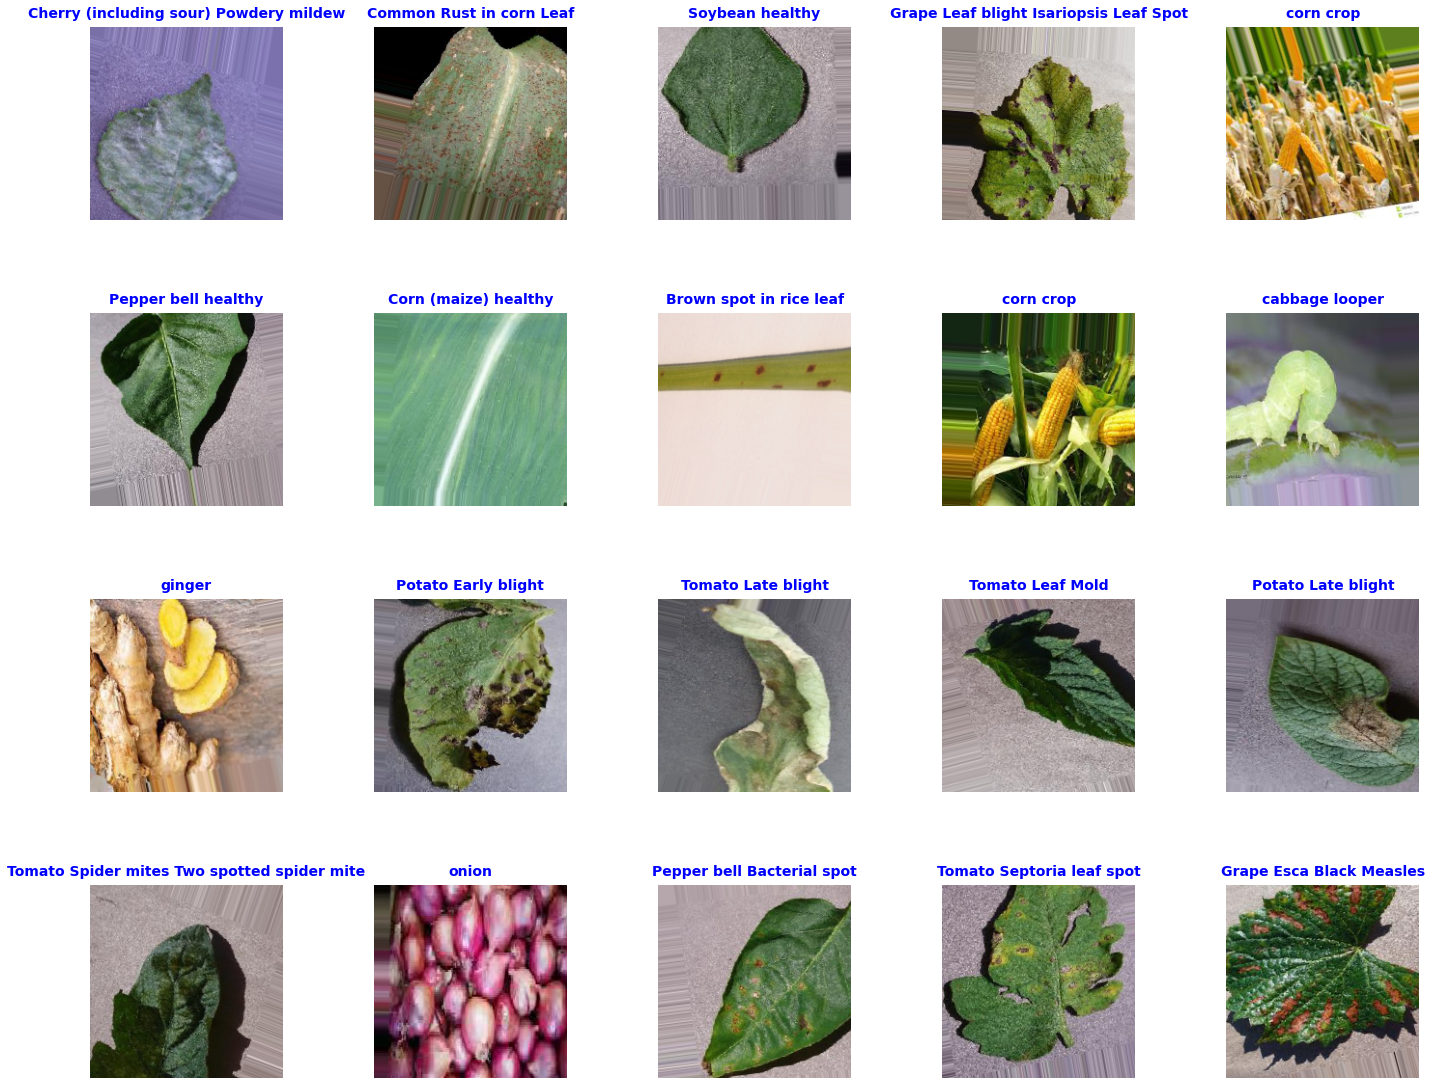

In [17]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=14)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen )

Create a model using transfer learning with EfficientNetB3

In [18]:
img_shape=(img_size[0], img_size[1], 3)
model_name='EfficientNetB3'
base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 

base_model.trainable=True
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.4, seed=123)(x)       
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
lr=.001 # start with this learning rate
model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 

43941136/43941136 [==============================] - 2s 0us/step


In [19]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: 
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False 
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training  
        print('loading model with weights from epoch ', self.best_epoch)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if v_loss< self.lowest_vloss:
            self.lowest_vloss=v_loss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1
            print (f'\n validation loss of {v_loss:7.4f} is below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights')
        else:
            print (f'\n validation loss of {v_loss:7.4f} is above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights')
        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                        print(f'current LR is  {lr:7.5f}  hit enter to keep  this LR or enter a new LR')
                        ans=input(' ')
                        if ans =='':
                            print (f'keeping current LR of {lr:7.5f}')
                        else:
                            new_lr=float(ans)
                            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                            print(' changing LR to ', ans)

In [20]:
epochs=40
ask_epoch=5
ask=LR_ASK(model, epochs,  ask_epoch)
#rlronp=tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2,verbose=1)
#callbacks=[rlronp, ask]
callbacks=[ask]

Training will proceed until epoch 5  then we will be asked to enter H to halt training or enter an integer for how many more epochs to run then be asked again


In [21]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
560/560 [==============================] - ETA: 0s - loss: 6.8059 - accuracy: 0.6455
 validation loss of  3.8533 is below lowest loss, saving weights from epoch 1   as best weights
560/560 [==============================] - 360s 595ms/step - loss: 6.8059 - accuracy: 0.6455 - val_loss: 3.8533 - val_accuracy: 0.9061
Epoch 2/40
560/560 [==============================] - ETA: 0s - loss: 2.6986 - accuracy: 0.9098
 validation loss of  1.6205 is below lowest loss, saving weights from epoch 2   as best weights
560/560 [==============================] - 311s 554ms/step - loss: 2.6986 - accuracy: 0.9098 - val_loss: 1.6205 - val_accuracy: 0.9524
Epoch 3/40
560/560 [==============================] - ETA: 0s - loss: 1.3027 - accuracy: 0.9433
 validation loss of  0.8825 is below lowest loss, saving weights from epoch 3   as best w

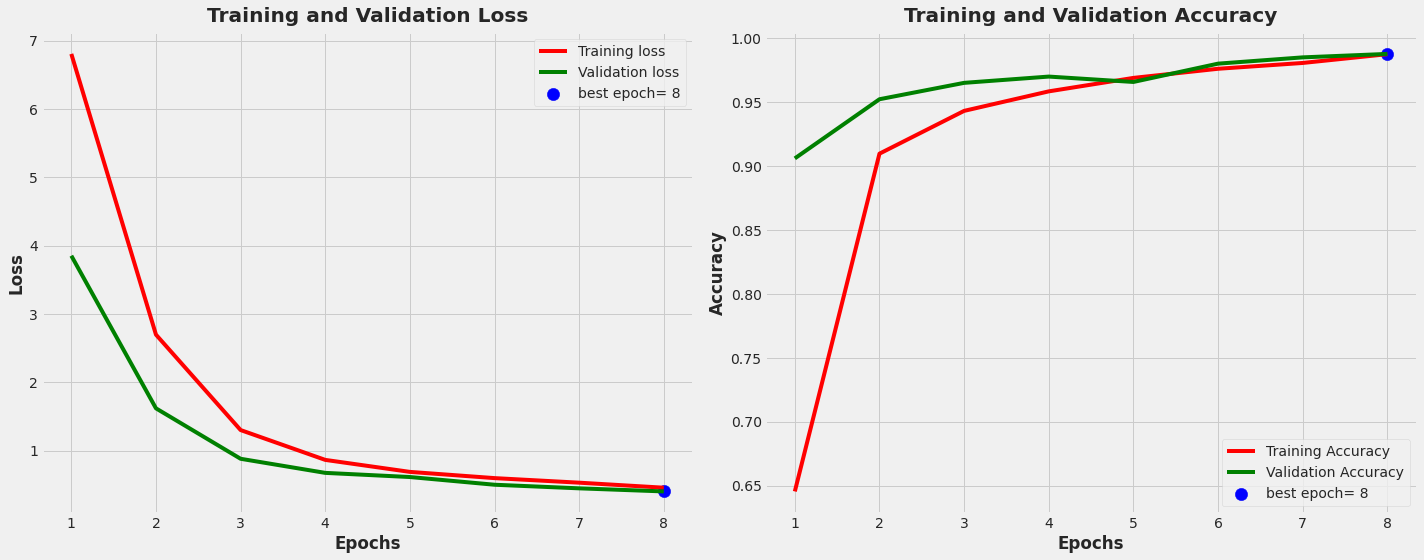

In [22]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    
tr_plot(history,0)

In [23]:
def predictor(test_gen, test_steps):
    y_pred= []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100 
    print(f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}')
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests
errors, tests=predictor(test_gen, test_steps)

1109/1109 [==============================] - 63s 54ms/step
there were 124 errors in 9981 tests for an accuracy of  98.76
Classification Report:
----------------------
                                              precision    recall  f1-score   support

                           Apple Apple scab     0.9967    0.9934    0.9950       303
                            Apple Black rot     0.9967    1.0000    0.9983       298
                     Apple Cedar apple rust     1.0000    1.0000    1.0000       132
                              Apple healthy     0.9851    1.0000    0.9925       198
         Bacterial leaf blight in rice leaf     0.8571    1.0000    0.9231         6
                        Blight in corn Leaf     0.9545    0.8547    0.9018       172
                          Blueberry healthy     1.0000    0.9890    0.9944       181
                    Brown spot in rice leaf     1.0000    1.0000    1.0000         6
                       Cercospora leaf spot     0.9000    1.0000  

In [29]:
classes


['Apple Apple scab',
 'Apple Black rot',
 'Apple Cedar apple rust',
 'Apple healthy',
 'Bacterial leaf blight in rice leaf',
 'Blight in corn Leaf',
 'Blueberry healthy',
 'Brown spot in rice leaf',
 'Cercospora leaf spot',
 'Cherry (including sour) Powdery mildew',
 'Cherry (including_sour) healthy',
 'Common Rust in corn Leaf',
 'Corn (maize) healthy',
 'Garlic',
 'Grape Black rot',
 'Grape Esca Black Measles',
 'Grape Leaf blight Isariopsis Leaf Spot',
 'Grape healthy',
 'Gray Leaf Spot in corn Leaf',
 'Leaf smut in rice leaf',
 'Orange Haunglongbing Citrus greening',
 'Peach healthy',
 'Pepper bell Bacterial spot',
 'Pepper bell healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Potato healthy',
 'Raspberry healthy',
 'Sogatella rice',
 'Soybean healthy',
 'Strawberry Leaf scorch',
 'Strawberry healthy',
 'Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',


In [32]:
score,accuracy =model.evaluate(test_gen,verbose=1)
print("Test score is {}".format(score))
print("Test accuracy is {}".format(accuracy))

1109/1109 [==============================] - 58s 46ms/step - loss: 0.4010 - accuracy: 0.9876
Test score is 0.4009920060634613
Test accuracy is 0.9875763654708862


In [60]:
subject='plant_disease' 
acc=str(( 1-errors/tests) * 100)
index=acc.rfind('.')
acc=acc[:index + 3]
save_id= subject + '.h5' 
krishicare=os.path.join(working_dir, save_id)
model.save(krishicare)
print ('model was saved as ' , krishicare ) 
   

model was saved as  ./plant_disease.h5


In [61]:
# Loading model and predict.
from keras.models import load_model
model=load_model('plant_disease.h5')

In [62]:
classe = train_gen.class_indices 
classe


{'Apple Apple scab': 0,
 'Apple Black rot': 1,
 'Apple Cedar apple rust': 2,
 'Apple healthy': 3,
 'Bacterial leaf blight in rice leaf': 4,
 'Blight in corn Leaf': 5,
 'Blueberry healthy': 6,
 'Brown spot in rice leaf': 7,
 'Cercospora leaf spot': 8,
 'Cherry (including sour) Powdery mildew': 9,
 'Cherry (including_sour) healthy': 10,
 'Common Rust in corn Leaf': 11,
 'Corn (maize) healthy': 12,
 'Garlic': 13,
 'Grape Black rot': 14,
 'Grape Esca Black Measles': 15,
 'Grape Leaf blight Isariopsis Leaf Spot': 16,
 'Grape healthy': 17,
 'Gray Leaf Spot in corn Leaf': 18,
 'Leaf smut in rice leaf': 19,
 'Orange Haunglongbing Citrus greening': 20,
 'Peach healthy': 21,
 'Pepper bell Bacterial spot': 22,
 'Pepper bell healthy': 23,
 'Potato Early blight': 24,
 'Potato Late blight': 25,
 'Potato healthy': 26,
 'Raspberry healthy': 27,
 'Sogatella rice': 28,
 'Soybean healthy': 29,
 'Strawberry Leaf scorch': 30,
 'Strawberry healthy': 31,
 'Tomato Bacterial spot': 32,
 'Tomato Early blight': 

In [63]:
from keras.models import load_model
model=load_model('plant_disease.h5')
classes

['Apple Apple scab',
 'Apple Black rot',
 'Apple Cedar apple rust',
 'Apple healthy',
 'Bacterial leaf blight in rice leaf',
 'Blight in corn Leaf',
 'Blueberry healthy',
 'Brown spot in rice leaf',
 'Cercospora leaf spot',
 'Cherry (including sour) Powdery mildew',
 'Cherry (including_sour) healthy',
 'Common Rust in corn Leaf',
 'Corn (maize) healthy',
 'Garlic',
 'Grape Black rot',
 'Grape Esca Black Measles',
 'Grape Leaf blight Isariopsis Leaf Spot',
 'Grape healthy',
 'Gray Leaf Spot in corn Leaf',
 'Leaf smut in rice leaf',
 'Orange Haunglongbing Citrus greening',
 'Peach healthy',
 'Pepper bell Bacterial spot',
 'Pepper bell healthy',
 'Potato Early blight',
 'Potato Late blight',
 'Potato healthy',
 'Raspberry healthy',
 'Sogatella rice',
 'Soybean healthy',
 'Strawberry Leaf scorch',
 'Strawberry healthy',
 'Tomato Bacterial spot',
 'Tomato Early blight',
 'Tomato Late blight',
 'Tomato Leaf Mold',
 'Tomato Septoria leaf spot',
 'Tomato Spider mites Two spotted spider mite',


In [64]:
# Pre-Processing test data same as train data.
from PIL import Image
img_width=256
img_height=256
model.compile(optimizer='adamax',loss='categorical_crossentropy',metrics=['accuracy'])
from keras.preprocessing import image
def prepare(img_path):
    image = np.array(Image.open(img_path).resize((200, 200)))
    img = tf.keras.utils.load_img(img_path, target_size=(200, 200))
    x = tf.keras.utils.img_to_array(img)
    x = x/256
    return np.expand_dims(x, axis=0)
    
    


1/1 [==============================] - 2s 2s/step
[[0.00358813 0.00494498 0.00271424 0.0176495  0.0145788  0.04562227
  0.00339139 0.014758   0.02081655 0.00711297 0.00706878 0.00433878
  0.00911772 0.0057106  0.01053208 0.00581115 0.00762077 0.0175834
  0.02590518 0.00623397 0.02194371 0.01127502 0.00490401 0.04598564
  0.00588937 0.00794095 0.01298395 0.00957477 0.02408016 0.07170249
  0.00884565 0.00811731 0.01985224 0.0156313  0.02442999 0.01433158
  0.01573843 0.00631063 0.01916781 0.00433208 0.02003222 0.00626872
  0.00607872 0.00690401 0.00834712 0.01865974 0.06013919 0.01512638
  0.0504178  0.0251911  0.00503917 0.01541866 0.01744545 0.00629173
  0.00912109 0.14138253]]


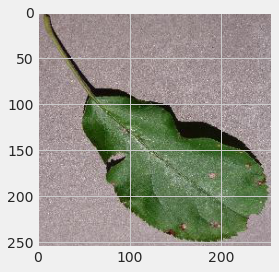

In [65]:
result = model.predict([prepare('/content/Image Data base/Image Data base/Apple Black rot/Apple_Black_rot1036.jpg')])
disease=tf.keras.utils.load_img('/content/Image Data base/Image Data base/Apple Black rot/Apple_Black_rot1036.jpg')
plt.imshow(disease)
print (result)

In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
 f.write(tflite_model)
     


